## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/)

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

There are two data files to train and validate your model: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016) 
    Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - 20dollars fee assigned to responsible judgments
    state_fee - 10dollars fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Objective

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [1]:
#Import the required libraries.
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from datetime import datetime
from dateutil import relativedelta
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier 
import seaborn as sns
from matplotlib import pyplot as plt
%run -i '/home/juan-david/Documents/data_science/travail_personnel/machine_learning_michigan_university/week_4/assignment_4/assignment_helper_functions.py'

In [2]:
#Import the dataframes.
blight_df_train = pd.read_csv('train.csv', engine='python')
blight_df_test = pd.read_csv('test.csv', engine='python')

In [3]:
#Avoiding null values in the response label.

#Counting the proportion of nan values in the df.
y = blight_df_train['compliance']
y.columns = ['compliance']

#Calculate how many rows in the target variable are nan.
nan_percentage = y.isnull().sum()/y.shape[0]

#Erease rows having nan values in target.
index_nan = y.index[y.apply(np.isnan)].tolist()
y = y.drop(y.index[[index_nan]])
y = y.reset_index(drop=True)

#Assign to X matrixes the values obtained from the datasets.
blight_df_train = blight_df_train.drop(blight_df_train.index[[index_nan]])
X = blight_df_train
X = X.reset_index(drop=True)
features = ['ticket_id','agency_name','inspector_name','violator_name','violation_street_number','violation_street_name','violation_zip_code','mailing_address_str_number','mailing_address_str_name','city','state','zip_code','non_us_str_code','country','ticket_issued_date','hearing_date' ,'violation_code','violation_description','disposition','fine_amount','admin_fee','state_fee','late_fee','discount_amount','clean_up_cost','judgment_amount','grafitti_status']  
X = X[features]

X_test = blight_df_test
X_test = X_test[features]

print(y.shape)
print(X.shape)
print(X_test.shape)
print("")
print(X_test['ticket_id'].head(15))

/home/juan-david/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


(159880,)
(159880, 27)
(61001, 27)

0     284932
1     285362
2     285361
3     285338
4     285346
5     285345
6     285347
7     285342
8     285530
9     284989
10    285344
11    285343
12    285340
13    285341
14    285349
Name: ticket_id, dtype: int64


<h3>1. Test set adjustment</h3>
<p>Guaranteeing the test set meet all the requirements for the evaluation phase.</p>

In [4]:
number_of_nulls = X_test.isnull().sum().sum()
print(number_of_nulls)

X_test = adjust_X_test(X_test)
number_of_nulls = X_test.isnull().sum().sum()
print(number_of_nulls)

160335
0


In [5]:
print(X_test.shape)
print(X_test['ticket_id'].head(10))

(61001, 27)
0    284932
1    285362
2    285361
3    285338
4    285346
5    285345
6    285347
7    285342
8    285530
9    284989
Name: ticket_id, dtype: int64


<h3>2. Data preparation</h3>
<p>Prepare the datasets X, y, and X_test to resolve the property maintenance fines problem in the city of Detroit, the largest in the state of Michigan, which location in the border between US and Canada.</p>

In [6]:
X, ticket_issued_date, index_ticket_issued_date = delete_rows_ticket_issued_date_is_na(X)

#Update y.
y = y[y.index.isin(index_ticket_issued_date)]
y = y.reset_index(drop=True)
#Update X-test
X_test, ticket_issued_date_test, index_ticket_issued_date_test = delete_rows_ticket_issued_date_is_na(X_test)

print(X.shape)
print(y.shape)
print(X_test.shape)

(159880, 27)
(159880,)
(61001, 27)


In [7]:
X, hearing_date, index_hearing_date = delete_rows_hearing_date_is_na(X)

#Update y.
y = y[y.index.isin(index_hearing_date)]
y = y.reset_index(drop=True)

#Update X, and X-test
X_test, hearing_date_test, index_hearing_date_test = delete_rows_hearing_date_is_na(X_test)

print(X.shape)
print(y.shape)
print(X_test.shape)

(159653, 27)
(159653,)
(61001, 27)


In [8]:
#Update  X-test
X = diff_months_tiket_issued_and_hearing_date(X)

#Calculate the n_months column for the X_test sample.
X_test = diff_months_tiket_issued_and_hearing_date(X_test)

print(X.shape)
print(y.shape)
print(X_test.shape)

(159653, 28)
(159653,)
(61001, 28)


In [9]:
#Update X.
X, index_correct_rows = df_correct_issued_date_later_than_hearing_date(X, False)

#Update y.
y = y[y.index.isin(index_correct_rows)]
y = y.reset_index(drop=True)

#Update X-test
X_test = df_correct_issued_date_later_than_hearing_date(X_test, True)

print(X.shape)
print(y.shape)
print(X_test.shape)

(159613, 28)
(159613,)
(61001, 28)


In [10]:
X, state, index_state = delete_rows_state_is_na(X)

#Update y
y = y[y.index.isin(index_state)]
y = y.reset_index(drop=True)

#Update hearing_date
hearing_date = hearing_date[hearing_date.index.isin(index_state)]
hearing_date = hearing_date.reset_index(drop=True)

#X_test
X_test, state_test, index_state_test = delete_rows_state_is_na(X_test)

#hearing_date_test
hearing_date_test = hearing_date_test[hearing_date_test.index.isin(index_state_test)]
hearing_date_test = hearing_date_test.reset_index(drop=True)

print(X.shape)
print(y.shape)
print(X_test.shape)

print("")
print(hearing_date.shape)
print(hearing_date_test.shape)
print(state.shape)
print(state_test.shape)

(159529, 28)
(159529,)
(61001, 28)

(159529,)
(61001,)
(159529,)
(61001,)


In [11]:
X, violation_code, index_violation_code = delete_rows_violation_code_is_na(X)

#Update y.
y = y[y.index.isin(index_violation_code)]
y = y.reset_index(drop=True)

#Update X_test.
X_test, violation_code_test, index_violation_code_test = delete_rows_violation_code_is_na(X_test)

#Update hearing_state
hearing_date = hearing_date[hearing_date.index.isin(index_violation_code)]
hearing_date = hearing_date.reset_index(drop=True)

hearing_date_test = hearing_date_test[hearing_date_test.index.isin(index_violation_code)]
hearing_date_test = hearing_date_test.reset_index(drop=True)

#Update state.
state = state[state.index.isin(index_violation_code)]
state = state.reset_index(drop=True)

print(X.shape)
print(y.shape)
print(X_test.shape)

print("")
print(hearing_date.shape)
print(hearing_date_test.shape)
print(state.shape)
print(state_test.shape)
print(violation_code.shape)
print(violation_code_test.shape)

(159529, 28)
(159529,)
(61001, 28)

(159529,)
(61001,)
(159529,)
(61001,)
(159529,)
(61001,)


In [12]:
#Update X.
X= drop_nan_columns(X)

#Update X_test.
features = X.columns
X_test = X_test[features]

print(X.dtypes)

print("")
print(X.shape)
print(y.shape)
print(X_test.shape)

ticket_id                         int64
agency_name                      object
inspector_name                   object
violator_name                    object
violation_street_number         float64
violation_street_name            object
mailing_address_str_number      float64
mailing_address_str_name         object
city                             object
state                            object
zip_code                         object
non_us_str_code                  object
country                          object
ticket_issued_date               object
hearing_date                     object
violation_code                   object
violation_description            object
disposition                      object
fine_amount                     float64
admin_fee                       float64
state_fee                       float64
late_fee                        float64
discount_amount                 float64
clean_up_cost                   float64
judgment_amount                 float64


In [13]:
columns_to_delete = ['violation_street_number','non_us_str_code','mailing_address_str_number']

#Update X.
X = drop_not_relevant_column(X,columns_to_delete)

#Update X_test.
features = X.columns
X_test = X_test[features]

print(X.dtypes)
print("")
print(X.shape)
print(y.shape)
print(X_test.shape)

ticket_id                         int64
agency_name                      object
inspector_name                   object
violator_name                    object
violation_street_name            object
mailing_address_str_name         object
city                             object
state                            object
zip_code                         object
country                          object
ticket_issued_date               object
hearing_date                     object
violation_code                   object
violation_description            object
disposition                      object
fine_amount                     float64
admin_fee                       float64
state_fee                       float64
late_fee                        float64
discount_amount                 float64
clean_up_cost                   float64
judgment_amount                 float64
n_months_diff_issued_hearing      int64
dtype: object

(159529, 23)
(159529,)
(61001, 23)


In [14]:
ratio_best_payed_inspector_name, list_names_ratio_best_inspector_name = find_best_ratio_of_payment_column(X['inspector_name'], y, "inspector_name", "compliance", 20)

print(ratio_best_payed_inspector_name.shape)
print(ratio_best_payed_inspector_name.head(5))

print(list_names_ratio_best_inspector_name)
print(len(list_names_ratio_best_inspector_name))

(20, 1)
                   ratio_best_payed
inspector_name                     
Thomas, Duane                   1.0
Coleman, Lanetha                1.0
Hischke, William                1.0
BENNETT, MARGARET               0.5
Long, Phil                      0.4
['Thomas, Duane', 'Coleman, Lanetha', 'Hischke, William', 'BENNETT, MARGARET', 'Long, Phil', 'Pickens, William', 'Frinkley, Elaine', 'Madrigal, Michael', 'Wilcox, Valerie', 'Gibson, Christopher', 'Brinkley, Kevin', 'Crowder, Michael', 'Johnson, Clifford', 'Smith, Melvin', 'Anderson, Trevis', 'Shah , Kumarpal', 'Copty, Anton', 'Zawislak, Norbet', 'Holbrook, Kevin', 'Fulks, Matthew g']
20


In [15]:
df_frequents_inspector_name, list_names_inspector_name = most_frequent_values_in_feature(X['inspector_name'], y , 5)

print(df_frequents_inspector_name)
print(len(list_names_inspector_name))

                  n_tickets
inspector_name             
Morris, John          11604
Samaan, Neil J         8699
O'Neal, Claude         8067
Steele, Jonathan       6957
Devaney, John          6837
5


In [16]:
X = encode_dummy_given_list(X,list_names_inspector_name,"inspector_name")

#Update X_test
X_test = encode_dummy_given_list(X_test,list_names_inspector_name,"inspector_name")

print(X.shape)
print(y.shape)
print(X_test.shape)

(159529, 27)
(159529,)
(61001, 27)


In [17]:
#Calculate best ratio payments for violation code.
ratio_best_payed_violation_code, list_names_ratio_best_violation_code = find_best_ratio_of_payment_column(violation_code, y, "violation_code", "compliance", 5)

print(ratio_best_payed_violation_code.shape)
print(ratio_best_payed_violation_code.head(5))
print("")
print(list_names_ratio_best_violation_code)
print(len(list_names_ratio_best_violation_code))

(5, 1)
                      ratio_best_payed
violation_code                        
61-47.0000/47.0108                 1.0
9-1-83 - (Building 5               0.5
19840901                           0.5
22-2-87(a)                         0.5
9-1-333                            0.5

['61-47.0000/47.0108', '9-1-83 - (Building 5', '19840901', '22-2-87(a)', '9-1-333']
5


In [18]:
#Calculate the most frequent values for the column violation_code.
df_frequents_violation_code, list_names_violation_code = most_frequent_values_in_feature(violation_code, y , 5)

print(df_frequents_violation_code)
print(len(list_names_violation_code))

                n_tickets
violation_code           
9-1-36(a)           64335
9-1-81(a)           23133
22-2-88             18989
9-1-104             16871
22-2-88(b)           4821
5


In [19]:
#Encode values of violation_code found with the best violation_code..
#Update X.
X = encode_dummy_given_list(X, list_names_violation_code, "violation_code")

#Update X_test.
X_test = encode_dummy_given_list(X_test, list_names_violation_code, "violation_code")

print(X.shape)
print(y.shape)
print(X_test.shape)

(159529, 31)
(159529,)
(61001, 31)


In [20]:
#Calculate best ratio payments for the column state.
ratio_best_payed_state, list_names_ratio_best_state = find_best_ratio_of_payment_column(state, y, "state", "compliance", 20)

print(ratio_best_payed_state.shape)
print(ratio_best_payed_state.head(5))
print("")
print(list_names_ratio_best_state)
print(len(list_names_ratio_best_state))

(20, 1)
       ratio_best_payed
state                  
QL             1.000000
HI             0.333333
RI             0.266667
KS             0.230769
NH             0.222222

['QL', 'HI', 'RI', 'KS', 'NH', 'NB', 'KY', 'CO', 'SD', 'OH', 'IL', 'MD', 'AK', 'WY', 'WA', 'NY', 'MI', 'NJ', 'WI', 'ON']
20


In [21]:
#Calculate the most frequent values for the column state.
df_frequents_state, list_names_state = most_frequent_values_in_feature(state, y , 5)

print(df_frequents_state)
print(len(list_names_state))

       n_tickets
state           
MI        143415
CA          3823
TX          1946
FL          1679
SC          1066
5


In [22]:
#Encode values of violation_code found with the best state ratio.
#Update X.
X = encode_dummy_given_list(X, list_names_state, "state")

#Update X_test.
X_test = encode_dummy_given_list(X_test, list_names_state, "state")

print(X.shape)
print(y.shape)
print(X_test.shape)

(159529, 35)
(159529,)
(61001, 35)


In [23]:
#Update X.
X = drop_too_many_categories_in_column(X)

#Update X_test.
features = X.columns
X_test = X_test[features]

print(X.dtypes)

print("")
print(X.shape)
print(y.shape)
print(X_test.shape)

ticket_id                            int64
agency_name                         object
country                             object
disposition                         object
fine_amount                        float64
admin_fee                          float64
state_fee                          float64
late_fee                           float64
discount_amount                    float64
clean_up_cost                      float64
judgment_amount                    float64
n_months_diff_issued_hearing         int64
inspector_name_Morris, John          int64
inspector_name_Samaan, Neil J        int64
inspector_name_O'Neal, Claude        int64
inspector_name_Steele, Jonathan      int64
inspector_name_Devaney, John         int64
violation_code_9-1-36(a)             int64
violation_code_9-1-81(a)             int64
violation_code_22-2-88               int64
violation_code_9-1-104               int64
violation_code_22-2-88(b)            int64
state_MI                             int64
state_CA   

In [24]:
#Extract the new variables from the feauture X set.
hearing_date_status, hearing_date_months = hearing_date_feature_extraction(hearing_date)

#Extract the new variables from the feauture X_test set.
hearing_date_status_test, hearing_date_months_test = hearing_date_feature_extraction(hearing_date_test)

print("")
print(X.shape)
print(y.shape)
print(X_test.shape)

print("")
print(hearing_date_status.shape)
print(hearing_date_months.shape)
print("")
print(hearing_date_status_test.shape)
print(hearing_date_months_test.shape)


(159529, 27)
(159529,)
(61001, 27)

(159529, 1)
(159529, 1)

(61001, 1)
(61001, 1)


<h3>2. Engineering Data Analysis (EDA)</h3>
<p>Check the relevance of some categorical features in relationship with the target variable.The analysis focuses over some extracted variables during the preparation phase.</p>
<ul>
<li>The variables of interest are n_months_difference, hearing_status, state, inspector_name, and violation_code.</li>
</ul>

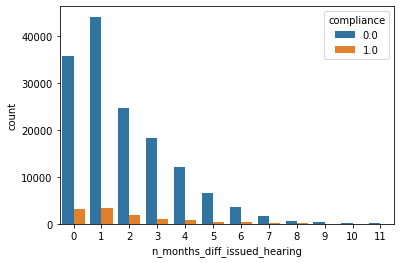

contingency_table
compliance                      0.0   1.0
n_months_diff_issued_hearing             
0                             35734  3152
1                             44123  3471
2                             24704  1791
3                             18201  1114
4                             12120   743
5                              6505   402
6                              3527   375
7                              1762   181
8                               699   115
9                               404    44
10                              214    23
11                              117     8

[ 0 10  8  6  4  7  1  2  5  3  9 11]
n_months_diff_issued_hearing
0     38886
1     47594
2     26495
3     19315
4     12863
5      6907
6      3902
7      1943
8       814
9       448
10      237
11      125
dtype: int64


In [25]:
#Check the changes in the target variable in regards to the variable n_months_difference. 
df_diff_months = pd.concat([X['n_months_diff_issued_hearing'], y], axis =1)

sns.countplot(data=df_diff_months, x='n_months_diff_issued_hearing',hue = 'compliance')
plt.show()

print("contingency_table")
print(pd.crosstab(df_diff_months["n_months_diff_issued_hearing"], df_diff_months["compliance"]))

print("")
print(X['n_months_diff_issued_hearing'].unique())
print(X.groupby('n_months_diff_issued_hearing').size())

(159529, 2)


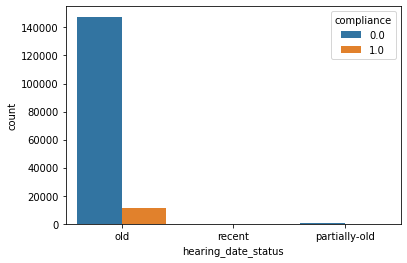

contingency_table
compliance              0.0    1.0
hearing_date_status               
old                  147508  11268
partially-old           600    151
recent                    2      0


In [26]:
#Analyse whether the column hearing_date_status is relevant for the target.
#Countplots are created.
df_status = pd.concat([y, hearing_date_status], axis =1)
print(df_status.shape)
sns.countplot(data=df_status, x='hearing_date_status',hue = 'compliance')
plt.show()

print("contingency_table")
print(pd.crosstab(df_status["hearing_date_status"], df_status["compliance"]))

(159529, 2)


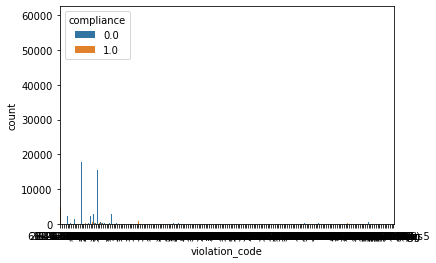

(159529, 2)

contingency_table
compliance             0.0  1.0
violation_code                 
19420901                12    4
19450901              1574   45
19830901                10    0
19840901                 1    1
19850901                 1    0
...                    ...  ...
9-1-82(d) - (Dwellin   443   13
9-1-82(d) - (Structu    15    2
9-1-83 - (Building 5     1    1
9-1-83 - (Dwelling)     64    1
9-1-83 - (Structures    16    0

[189 rows x 2 columns]


In [27]:
#Analyse whether the column violation_code is relevant for the target.
#Countplots are created.
df_violation_code = pd.concat([violation_code, y], axis =1)
print(df_violation_code.shape)
sns.countplot(data=df_violation_code, x='violation_code',hue = 'compliance')
plt.show()
print(df_violation_code.shape)
print("")
print("contingency_table")
print(pd.crosstab(df_violation_code["violation_code"], df_violation_code["compliance"]))
#The most relevant are 19450901, 22-2-17, 22-2-43, 22-2-45, 9-1-81(a).s

(159529, 2)


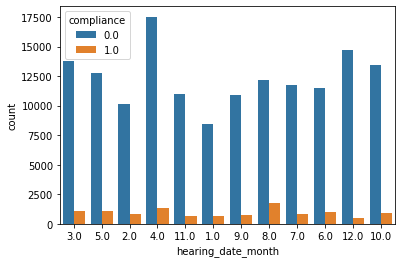

contingency_table
compliance            0.0   1.0
hearing_date_month             
1.0                  8438   632
10.0                13451   914
11.0                11024   661
12.0                14678   487
2.0                 10163   809
3.0                 13749  1126
4.0                 17524  1315
5.0                 12780  1102
6.0                 11528   980
7.0                 11738   870
8.0                 12158  1794
9.0                 10879   729


In [28]:
#Analyse whether the column hearing_dates_months is relevant for the target.
#Countplots are created.
df_month = pd.concat([hearing_date_months,y], axis =1)
print(df_month.shape)
sns.countplot(data=df_month, x='hearing_date_month',hue = 'compliance')
plt.show()

print("contingency_table")
print(pd.crosstab(df_month["hearing_date_month"], df_month["compliance"]))

In [29]:
#Check the balance of classes in the target variable.
#The relationship is almost 1 to 9 for the classes in the target variable.
y_classes = pd.DataFrame(y)
y_classes.columns = ['values']
print(y_classes['values'].value_counts(normalize=True))

0.0    0.928421
1.0    0.071579
Name: values, dtype: float64


<h3>3. Dataset encoding</h3>
<p>Transforming the dateset into all numerical entries. Features containing categorical values are converted into dummy vectors. It means that each category is represented by a vector of ones (1) and zeros (0).</p>
<ul>
<li>The procedure is done over the whole dataset because features on the train, and test sets might be equal.</li>
</ul>

In [30]:
#Define the number of rows in the X matrix.
n_X = X.shape[0]

#Concatenate vertically X, and X_test matrixes and encode them together.
concatenated_dataframes = pd.concat([X, X_test], axis=0)
concatenated_dataframes = pd.get_dummies(concatenated_dataframes)

#Split the X and X_test matrixes after been encoded.
X = concatenated_dataframes.iloc[0:n_X,:]
X_test = concatenated_dataframes.iloc[n_X:,:]

#Reshaping the y matrix into a vector (n,).
y = y.values.reshape(y.values.shape[0],)
print(y.shape)

print(X.dtypes)
print("")
print(X.shape)
print(y.shape)
print(X_test.shape)

(159529,)
ticket_id                                                       int64
fine_amount                                                   float64
admin_fee                                                     float64
state_fee                                                     float64
late_fee                                                      float64
discount_amount                                               float64
clean_up_cost                                                 float64
judgment_amount                                               float64
n_months_diff_issued_hearing                                    int64
inspector_name_Morris, John                                     int64
inspector_name_Samaan, Neil J                                   int64
inspector_name_O'Neal, Claude                                   int64
inspector_name_Steele, Jonathan                                 int64
inspector_name_Devaney, John                                    int64
violation_

<h3>4. Feature selection (dimensionality reduction)</h3>
<p>Select features having the strongest relationship with the target variable. Dimensionality reduction guarantees a best performance during the training phase</p>
<ul>
<li>In order to select the features, information gain is applied. It implies that features are selected satisfying the smallest lost of explained information when removing the variables</li>
<li>Information gain is done by minimizing the entropy of the matrix X once variables are put taken off/li>
</ul>

In [31]:
selected_features = feature_selection_information_gain(X, y, 15)

#Select the features according to their importance
X = X[selected_features]
X_test = X_test[selected_features]

print(selected_features)
print(X.shape)
print(X_test.shape)

                                                      values
disposition_Responsible by Default                  0.064811
judgment_amount                                     0.051907
late_fee                                            0.047391
state_fee                                           0.036754
admin_fee                                           0.036235
country_USA                                         0.034309
state_MI                                            0.027378
ticket_id                                           0.023575
disposition_Responsible by Admission                0.019126
discount_amount                                     0.015148
agency_name_Buildings, Safety Engineering & Env...  0.014008
fine_amount                                         0.012692
disposition_Responsible by Determination            0.012168
violation_code_9-1-36(a)                            0.005496
n_months_diff_issued_hearing                        0.005018
['disposition_Responsibl

In [32]:
selected_features_KBest = feature_selection_information_gain_KBest(X, y, 15)
print(selected_features_KBest)

['disposition_Responsible by Default', 'judgment_amount', 'late_fee', 'state_fee', 'admin_fee', 'country_USA', 'state_MI', 'ticket_id', 'disposition_Responsible by Admission', 'discount_amount', 'agency_name_Buildings, Safety Engineering & Env Department', 'fine_amount', 'disposition_Responsible by Determination', 'violation_code_9-1-36(a)', 'n_months_diff_issued_hearing']


<h3>5. Training phase and model selection</h3>
<p>Training multiple classifiers on the X matrix. After models are trained, the one having the best performance is selected.</p>
<ul>
<li>Hyperparameter tuning is done over each model. No more than 30 mins of training per model is satisfied</li>
<li>Classifiers like SVM, Logistic regression, Random forest, and Gradient boosting are used for the purpose of this phase.</li>
</ul>

In [36]:
#Train a logistic regresion classifier.
#Obtained AUC in test = 0.775

#Best AUC reached : 0.77909119. running best 20 and selectiog 30.
#Best AUC 0.78433477 running best 5 and selecting 18.
#Best AUC 0.77989349 running best 5 and selecting 10.
#Best AUC 0.78518753 running best 10 and selecting 25.

scaler = MinMaxScaler()
clf = LogisticRegression()
pipeline = Pipeline([('scaler',scaler), ('model', clf)])
grid_values = {'model__penalty': ['l1', 'l2'], 'model__C':[0.01, 0.1, 1, 10, 100]}
search = GridSearchCV(pipeline, grid_values, cv =5, scoring = "roc_auc").fit(X,y)

cv_result = search.cv_results_

print(cv_result.keys())

#mean_train_score = cv_result['mean_train_score']

mean_test_score = cv_result['mean_test_score']

#results_train = np.array(mean_train_score).reshape(5,2)

results = np.array(mean_test_score).reshape(5,2)

params = search.best_params_

#For each combination of parameters, there is an average of the auc metric calculated within a logistic regression classifier.
#L1,l2 as columns, and 0.01, 0.1, 0.1, 10, 100 as rows in the results matrix.
print(cv_result)
print('')
print('train')
#print(results_train)
print('')
print('test')
print(results)
print('')
print(params)
print('')

#Predict probabilities.
y_prob_logistic_regression = search.predict_proba(X)

print(y_prob_logistic_regression)

#Get probabilities.
y_prob_logistic_regression = get_probs_format(X,y_prob_logistic_regression)
print(y_prob_logistic_regression)

/home/juan-david/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juan-david/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juan-david/.local/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/juan-david/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/juan-david/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' p

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__C', 'param_model__penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'mean_fit_time': array([0.03431683, 1.20587296, 0.03556933, 2.49442525, 0.03528204,
       2.70979772, 0.03554378, 2.83204408, 0.0396172 , 2.97650361]), 'std_fit_time': array([0.00834852, 0.08620633, 0.00746257, 0.22107807, 0.00781637,
       0.19985257, 0.00749363, 0.10017361, 0.01084434, 0.17006033]), 'mean_score_time': array([0.        , 0.02825456, 0.        , 0.0267087 , 0.        ,
       0.02683234, 0.        , 0.02715964, 0.        , 0.03089728]), 'std_score_time': array([0.00000000e+00, 2.99651407e-03, 0.00000000e+00, 9.93076319e-05,
       0.00000000e+00, 2.79642492e-04, 0.00000000e+00, 7.83101455e-04,
       0.00000000e+00, 6.40328849e-03]), 'param_model__C': masked_array(data=[0.01, 

/home/juan-david/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
#Train a randomforest classifier with randomsearch.
#The classifier is tried with randomsearch to check the best parameters combinations that make better classifications.
#Crossvalidation is not performed with this classifier cause it is nessesary an X_test(validation) to evaluate the auc metric.
X = X[selected_features]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.20)

#The parameter class_weight='balanced_subsample' will check the proportion of labels of each class in each tree.
#Based on that, it will calculate the metric in favor to the minority class.
clf = RandomForestClassifier(class_weight='balanced_subsample')

#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [200]
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 210, num = 2)]
# Number of features to consider at every split
#max_features = ['auto']
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10]
#max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
#max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
#max_depth.append(None)
min_samples_split[2]
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
#bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#n_iter tells us the number of different combinations to try.
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring ="roc_auc")# Fit the random search model

#Training the classifier.
rf_random.fit(X_train, y_train)

#Print results
auc_train = roc_auc_score(y_train, rf_random.predict(X_train))
auc_test = roc_auc_score(y_val, rf_random.predict(X_val))

#Predict probabilities.
y_prob_random_forest_rs = grid_search.predict_proba(X_val)

print(rf_random.best_params_)
print(auc_train)
print(auc_test)

dprint(y_prob_random_forest_rs)

In [50]:
#Train a supporting vector machines classifier.
#from sklearn.model_selection import GridSearchCV, KFold

X = X[selected_features]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.20)

#The parameter class_weight='balanced_subsample' will check the proportion of labels of each class in each tree.
#Based on that, it will calculate the metric in favor to the minority class.
clf = SVC(class_weight='balanced', probability=True)

param_grid = {'C': [0.1, 1, 10, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
        
#param_grid = {'C': [1], 
  #            'gamma': [1],
  #            'kernel': ['rbf']}

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#Training the classifier.
grid_search.fit(X_train, y_train)

#Print results
auc_train = roc_auc_score(y_train, grid_search.predict(X_train))
auc_test = roc_auc_score(y_val, grid_search.predict(X_val))

#Predict probabilities
y_prob_SVM = grid_search.predict_proba(X_val)

print(grid_search.best_params_)
print(auc_train)
print(auc_test)

print("")
print(y_prob_SVM)

In [51]:
#Try a gradient boosting classifier on the problem.
#Obtained AUC in test = 0.623612649317

X = X[selected_features]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.20)

#The parameter class_weight='balanced_subsample' will check the proportion of labels of each class in each tree.
#Based on that, it will calculate the metric in favor to the minority class.
clf = GradientBoostingClassifier()

#Finding the optimal number of desicion trees.
#errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
#best_n_estimators = np.argmin(errors)

parameters = {
   "learning_rate": [0.01,0.05, 0.1],
    "n_estimators":[10,50,100],
   "subsample":[0.5, 0.8, 0.85]
}

#parameters = {
    #"loss":["deviance"],
    #"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    #"max_depth":[3,5,8],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #"n_estimators":[10]
#}


grid_search = GridSearchCV(estimator = clf, param_grid = parameters, scoring = "roc_auc", cv = 5, n_jobs = -1, verbose = 2)

#Training the classifier.
grid_search.fit(X_train, y_train)

#Print results
auc_train = roc_auc_score(y_train, grid_search.predict(X_train))
auc_test = roc_auc_score(y_val, grid_search.predict(X_val))

print(grid_search.best_params_)
print(auc_train)
print(auc_test)

#Predict probabilities
y_prob_GB = grid_search.predict_proba(X_val)

print(y_prob_GB)

<h3>6. Model evaluation on unseen data </h3>
<p>Evaluating how well the model performs on data that it hasn't seen before. The evaluation is performed over the X_test set.</p>
<ul>
<li>A Logistic Regression was selected as the best classifier to perform the prediction task for ticket compliance during the training and model selection phase </li>
<li>At the final part, probabilites of the given predictions are calculated.</li>
</ul>

In [52]:
#Logistic regression prediction over the test set.
#Predict probabilities.
y_prob_logistic_regression = search.predict_proba(X_test)
y_prob_logistic_regression = get_probs_format(X_test, y_prob_logistic_regression)
print(y_prob_logistic_regression)
print("")
print(y_prob_logistic_regression.shape)

ticket_id
284932    0.057680
285362    0.020298
285361    0.062121
285338    0.055008
285346    0.062120
285345    0.055009
285347    0.065990
285342    0.481184
285530    0.018669
284989    0.036749
285344    0.065990
285343    0.020297
285340    0.020297
285341    0.065990
285349    0.057326
285348    0.050734
284991    0.036749
285532    0.038018
285406    0.038014
285001    0.035770
285006    0.010449
285405    0.018667
285337    0.036759
285496    0.069186
285497    0.057706
285378    0.019617
285589    0.035016
285585    0.055019
285501    0.065143
285581    0.020301
            ...   
376367    0.014764
376366    0.050012
376362    0.348011
376363    0.236119
376365    0.014764
376364    0.050012
376228    0.052465
376265    0.052467
376286    0.293951
376320    0.050010
376314    0.050010
376327    0.283567
376385    0.283577
376435    0.465377
376370    0.496949
376434    0.074343
376459    0.070021
376478    0.000134
376473    0.052476
376484    0.027414
376482    0.019597
37

In [53]:
def blight_model():
    
    answer = y_prob_logistic_regression
    
    return answer

In [54]:
blight_model()

ticket_id
284932    0.057680
285362    0.020298
285361    0.062121
285338    0.055008
285346    0.062120
285345    0.055009
285347    0.065990
285342    0.481184
285530    0.018669
284989    0.036749
285344    0.065990
285343    0.020297
285340    0.020297
285341    0.065990
285349    0.057326
285348    0.050734
284991    0.036749
285532    0.038018
285406    0.038014
285001    0.035770
285006    0.010449
285405    0.018667
285337    0.036759
285496    0.069186
285497    0.057706
285378    0.019617
285589    0.035016
285585    0.055019
285501    0.065143
285581    0.020301
            ...   
376367    0.014764
376366    0.050012
376362    0.348011
376363    0.236119
376365    0.014764
376364    0.050012
376228    0.052465
376265    0.052467
376286    0.293951
376320    0.050010
376314    0.050010
376327    0.283567
376385    0.283577
376435    0.465377
376370    0.496949
376434    0.074343
376459    0.070021
376478    0.000134
376473    0.052476
376484    0.027414
376482    0.019597
37